# Run an agent based SEIRX simulation

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from scseirx.model_nursing_home import SEIRX_nursing_home
import viz

## Single model run

### Agents

Agent types used in the simulation with their respective parameters

In [31]:
agent_types = {
        'employee':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':False,
            'vaccination_ratio': 0.1 },
        'resident':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':False,
            'vaccination_ratio': 0.1 },
}

### Measures

Preventive measures implemented to curb the spread of the pandemic

In [32]:
measures = {
    # enables testing and tracing actions (run with testing=False) to simulate
    # unhindered spread of the virus through the nursing home
    'testing':'preventive',
    # test technology and turnover time used for preventive screening
    'preventive_screening_test_type':'same_day_antigen',
    # test technology and turnover time used for diagnostic testing
    'diagnostic_test_type':'two_day_PCR',
    # definition of contact types that will be quarantined in case one
    # of the agents in contact had a positive test result
    'K1_contact_types':['close'],
    # duration (in days) that agents will stay quarantined
    'quarantine_duration':10,
    # interval of a potential follow-up background screen (in days)
    # after a background screen that was initiated by a positive test
    'follow_up_testing_interval':None,
    # whether or not a negative test result "frees" agents from quarantine
    'liberating_testing':False,
    # modification of the transmission risk by ventilation 
    # (1 = no modification, 0.5 = risk is reduced by 50%)
    'ventilation_modification':1,
    # modification of the transmission risk by vaccination
    # (0 = no modification, 0.95 = risk reduction of BioN-Tech/Pfizer and Moderna) 
    'vaccination_modification':{'reception':0.8, 'transmission':0.0}
}


### Model parameters

In [33]:
model_params = {
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and becoming infectious (in days)
    'exposure_duration':[5.0, 1.9], # literature values
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and showing symptoms in clinical courses
    # of the infection (in days)
    'time_until_symptoms':[6.4, 0.8], # literature values
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and ceasing to be infectious (in days)
    'infection_duration':[10.91, 3.95], # literature values
    # modification of the transmission risk in subclinical courses
    'subclinical_modifier':0.6, 
    # base transmission risk of a contact of type "close"
    'base_risk':0.07, # artificially high, so you can see stuff happening
    # efficiency of masks (surgical), reducing the transmission risk
    # (exhale) if the source wears a mask and/or the reception risk 
    # (inhale), if the target (also) wears a mask
    'mask_filter_efficiency':{'exhale':0.5, 'inhale':0.7}, # literature values
    # modifiers of the base_risk for transmissions of contact type close
    # if the contact type is "intermediate", "far" or "very var"
    'infection_risk_contact_type_weights':\
        {'very_far':0, 'far':0.75, 'intermediate':0.85,'close':1}, 
    # agent group from which the index case is drawn
    'index_case':'employee',
    # verbosity level (can be 0, 1, 2) that prints increasingly detailed 
    # information about the simulation
    'verbosity':0
    
}

### Run the simulation

In [34]:
N_steps = 100
seed = 5

G = nx.readwrite.gpickle.read_gpickle(\
        'data/nursing_home/interactions_single_quarter.bz2')

model = SEIRX_nursing_home(G, model_params['verbosity'], 
      base_transmission_risk = model_params['base_risk'], 
      testing = measures['testing'],
      exposure_duration = model_params['exposure_duration'],
      time_until_symptoms = model_params['time_until_symptoms'],
      infection_duration = model_params['infection_duration'],
      quarantine_duration = measures['quarantine_duration'],                  
      subclinical_modifier = model_params['subclinical_modifier'], 
      infection_risk_contact_type_weights = \
            model_params['infection_risk_contact_type_weights'], 
      K1_contact_types = measures['K1_contact_types'],
      diagnostic_test_type = measures['diagnostic_test_type'],
      preventive_screening_test_type = \
            measures['preventive_screening_test_type'],
      follow_up_testing_interval = \
            measures['follow_up_testing_interval'],
      liberating_testing = measures['liberating_testing'],
      index_case = model_params['index_case'],
      agent_types = agent_types, 
      mask_filter_efficiency = model_params['mask_filter_efficiency'],
      transmission_risk_ventilation_modifier = \
            measures['ventilation_modification'],
      transmission_risk_vaccination_modifier = \
            measures['vaccination_modification'],
      seed=seed)

for i in range(N_steps):
    if model_params['verbosity'] > 0: 
        print()
        print('*** step {} ***'.format(i+1))
    # break if first outbreak is over
    if len([a for a in model.schedule.agents if \
        (a.exposed == True or a.infectious == True)]) == 0:
        break
    model.step()

### Visualise time-series of inhabitant infections

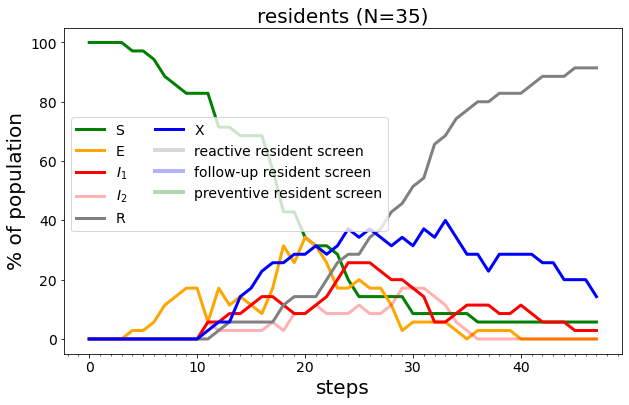

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'resident', ax)

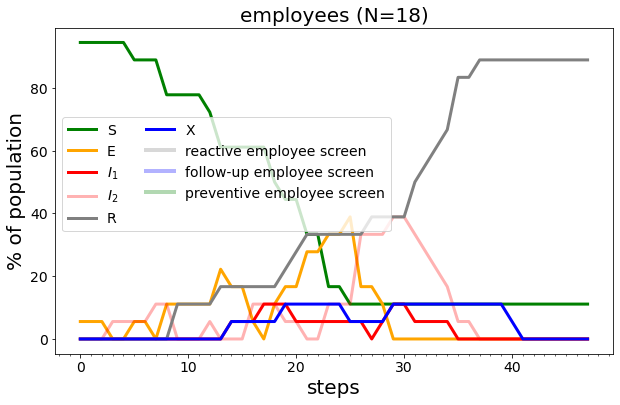

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'employee', ax)

### Visualise a snapshot of agent states

In [37]:
pos = nx.drawing.layout.spring_layout(G, dim=2, weight='weight')

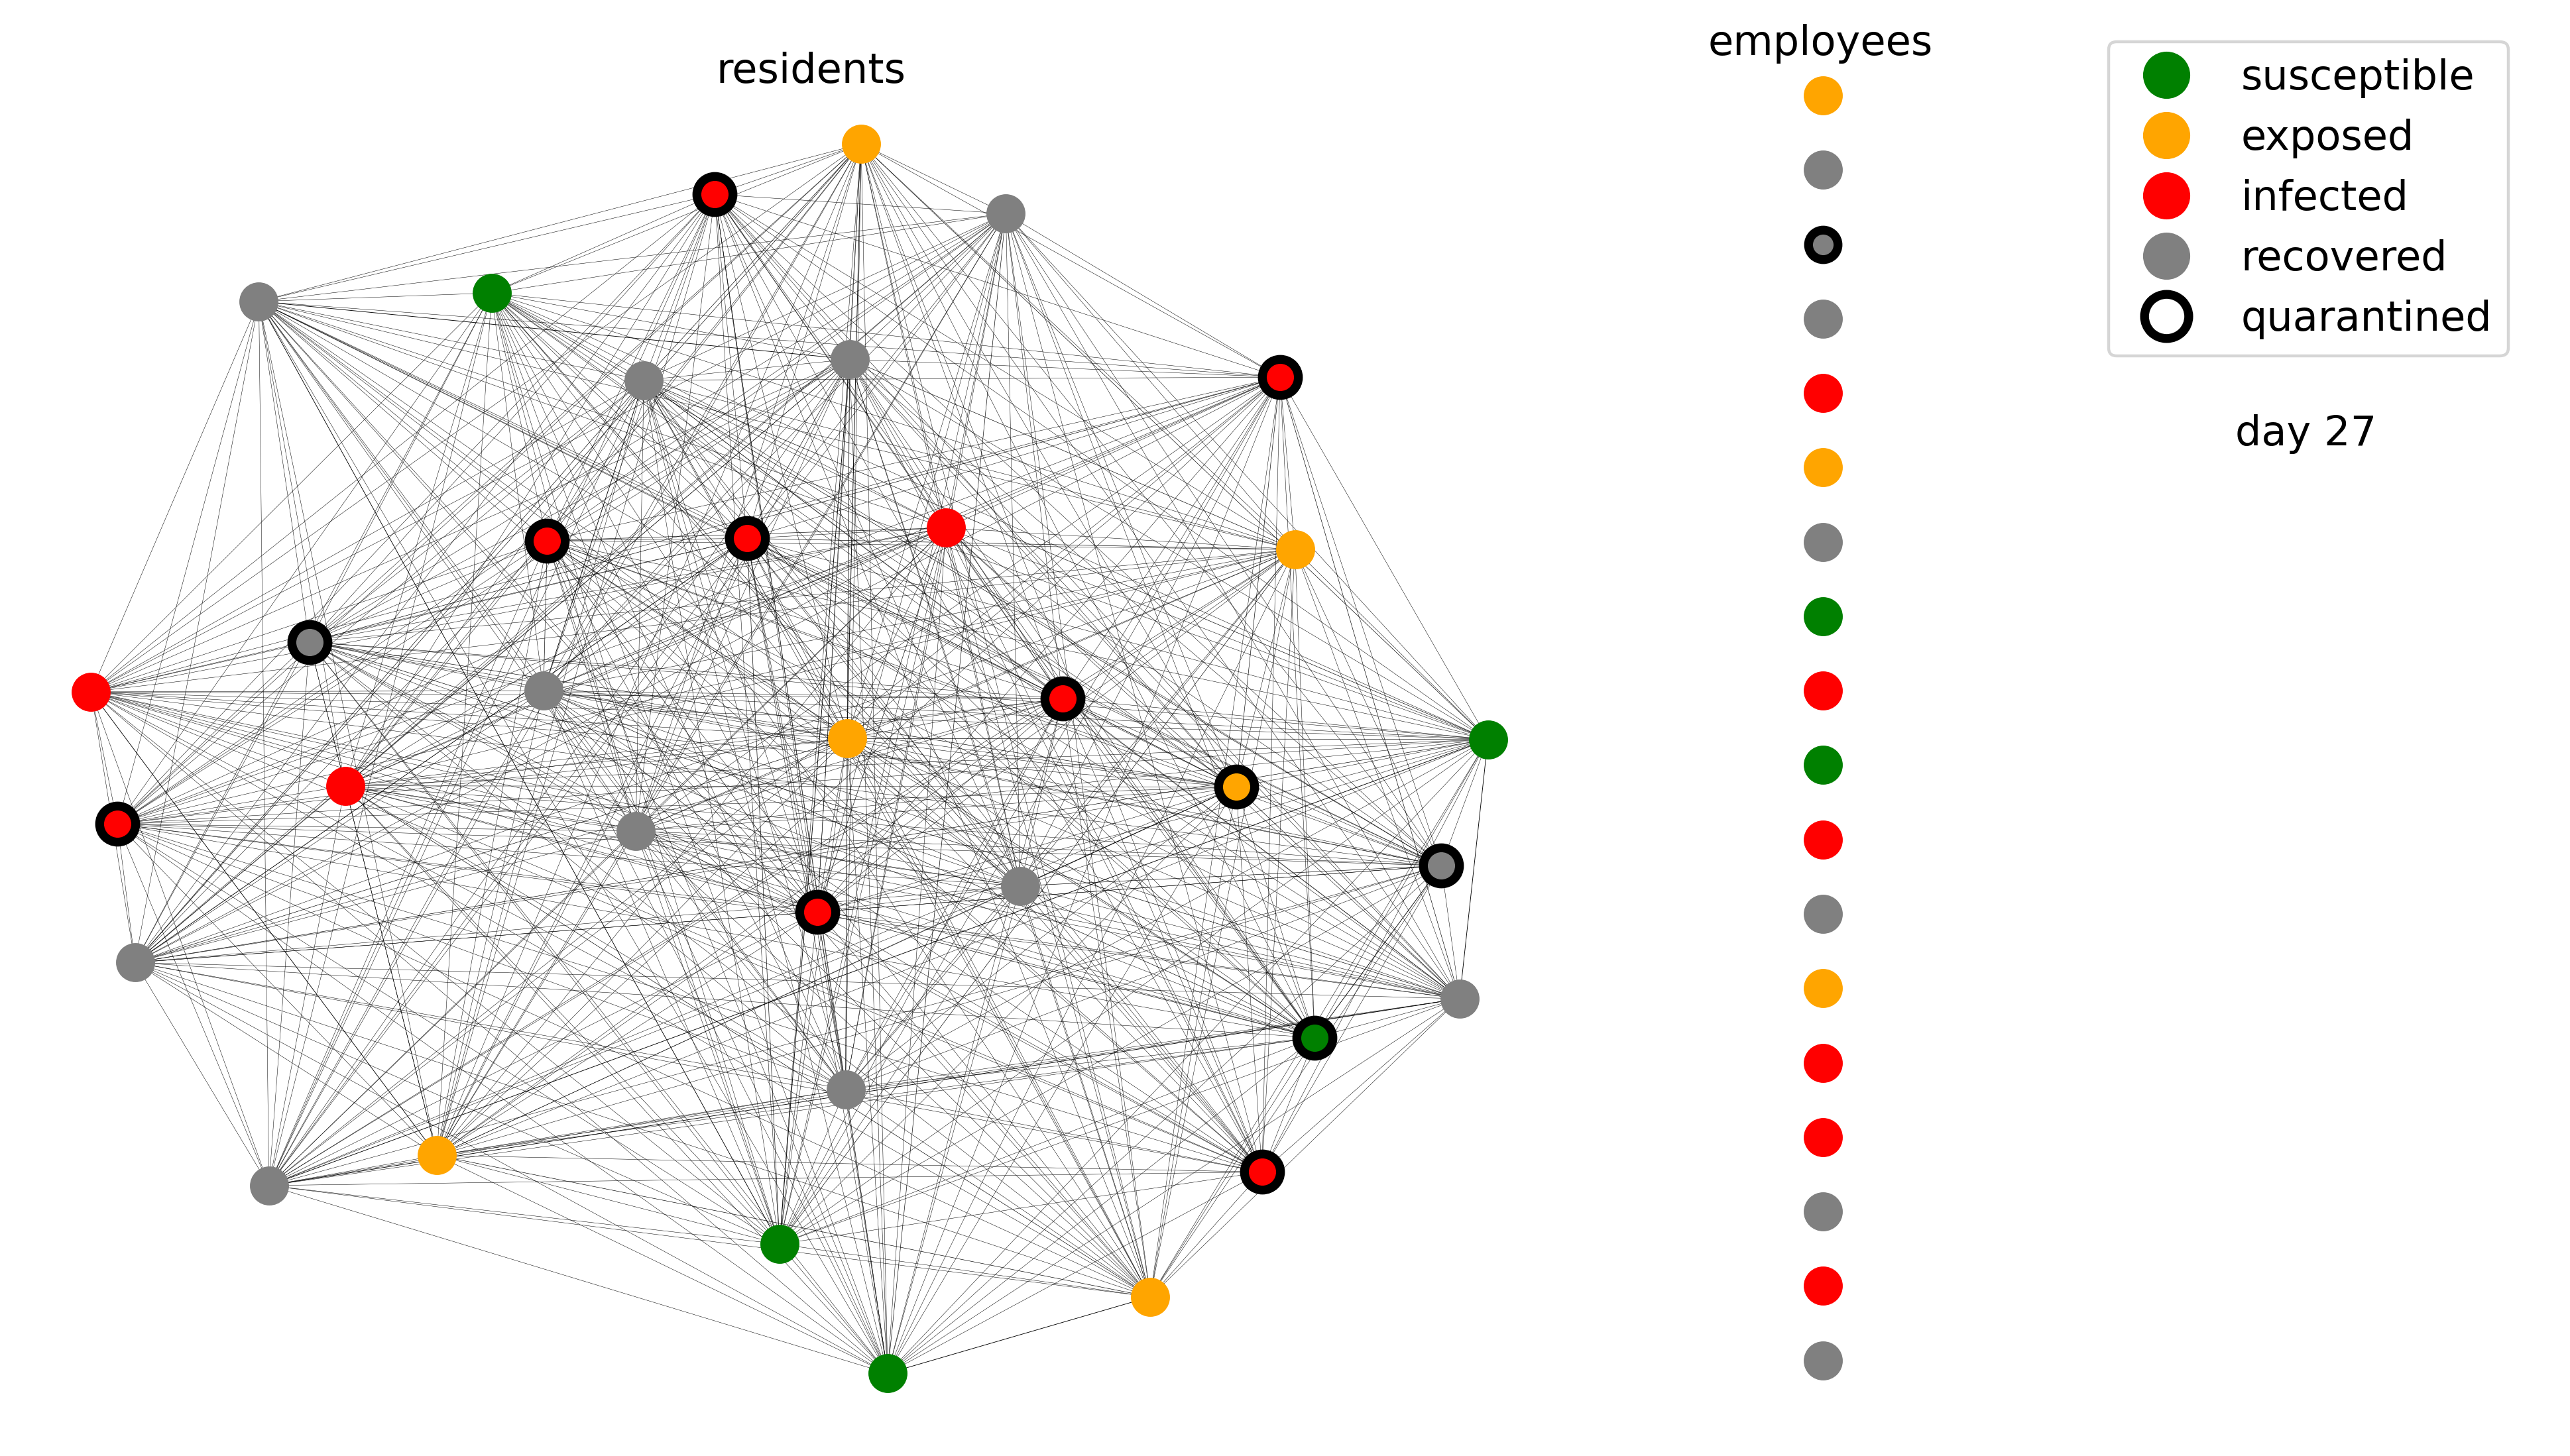

In [38]:
fig = plt.figure(constrained_layout=True,figsize=(12, 13.5/2), dpi=320)
widths = [5, 1.5, 1.5]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, wspace=0.0)

resident_ax = fig.add_subplot(spec[0])
employee_ax = fig.add_subplot(spec[1])
legend_ax = fig.add_subplot(spec[2])
    
legend, employee_handles, resident_handles, test_handle = viz.draw_states(model, 27, pos, \
                                    resident_ax, employee_ax, legend_ax)

### Have a peek at the raw data

In [39]:
data = model.datacollector.get_model_vars_dataframe()
data.head(2)

,S_employee,E_employee,I_employee,I_asymptomatic_employee,I_symptomatic_employee,R_employee,X_employee,V_employee,S_resident,E_resident,...,screen_residents_follow_up,screen_residents_preventive,screen_employees_reactive,screen_employees_follow_up,screen_employees_preventive,N_diagnostic_tests,N_preventive_screening_tests,undetected_infections,predetected_infections,pending_test_infections
0,17,1,0,0,0,0,0,2,35,0,...,False,False,False,False,False,0,0,0,0,0
1,17,1,0,0,0,0,0,2,35,0,...,False,False,False,False,False,0,0,0,0,0
